In [44]:
# %%
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
from matplotlib import animation as ani
from pathlib import Path

from tqdm.auto import tqdm

from IPython.core.display import HTML

__device__ = torch.device("cuda" if torch.cuda.is_available() else "cpu")
__file__ = Path(locals().get("__file__", "main.py")).resolve()
__root__ = __file__.parents[2]
__data__ = __root__ / "data"

print(f"{__device__=}\n{__file__=}\n{__root__=}\n{__data__=}")

__device__=device(type='cuda')
__file__=PosixPath('/home/n4okins/repositories/research_2/try/0708/main.py')
__root__=PosixPath('/home/n4okins/repositories/research_2')
__data__=PosixPath('/home/n4okins/repositories/research_2/data')


In [2]:
# load mnist

train_dataset = torchvision.datasets.MNIST(
    root=str(__data__), train=True, download=True, transform=transforms.ToTensor()
)
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True
)

input shape: torch.Size([8, 1, 28, 28])
labels: tensor([0, 4, 4, 6, 7, 2, 2, 8])


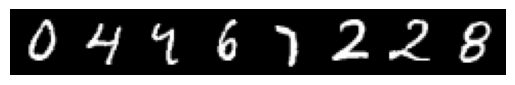

In [3]:
def sampling_plot():
    _train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=8,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )
    x, y = next(iter(_train_dataloader))
    print(f"input shape: {x.shape}")
    print(f"labels: {y}")
    plt.imshow(torchvision.utils.make_grid(x)[0], cmap="gray")
    plt.axis("off")
    plt.show()


sampling_plot()

input shape: torch.Size([8, 1, 28, 28])
labels: tensor([6, 8, 0, 5, 9, 2, 3, 0])
amount=tensor([0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571, 1.0000])


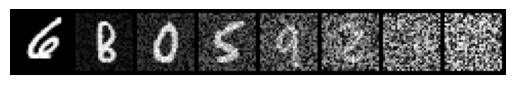

In [4]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
    return x * (1 - amount) + noise * amount


def sampling_corrupt_plot():
    _train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=8,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )
    x, y = next(iter(_train_dataloader))
    print(f"input shape: {x.shape}")
    print(f"labels: {y}")
    amount = torch.linspace(0, 1, x.shape[0])
    print(f"{amount=}")
    plt.imshow(torchvision.utils.make_grid(corrupt(x, amount))[0], cmap="gray")
    plt.axis("off")
    plt.show()


sampling_corrupt_plot()

In [130]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, hidden_size=32):
        super().__init__()
        self.down_sampling_layers = nn.ModuleList(
            [
                nn.Conv2d(in_channels, hidden_size, 5, padding=2),
                nn.Conv2d(hidden_size, hidden_size * 2, 5, padding=2),
                nn.Conv2d(hidden_size * 2, hidden_size * 2, 5, padding=2),
            ]
        )
        self.up_sampling_layers = nn.ModuleList(
            [
                nn.Conv2d(hidden_size * 2, hidden_size * 2, 5, padding=2),
                nn.Conv2d(hidden_size * 2, hidden_size, 5, padding=2),
                nn.Conv2d(hidden_size, out_channels, 5, padding=2),
            ]
        )
        self.activation = nn.ReLU()
        self.down_scale = nn.MaxPool2d(2)
        self.up_scale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        skip_connections = []

        for i, layer in enumerate(self.down_sampling_layers):
            x = self.activation(layer(x))
            if i < 2:
                skip_connections.append(x)
                x = self.down_scale(x)

        for j, layer in enumerate(self.up_sampling_layers):
            if j > 0:
                x = self.up_scale(x)
                skip = skip_connections.pop()
                x = x + skip
                x = self.activation(layer(x))
        return x

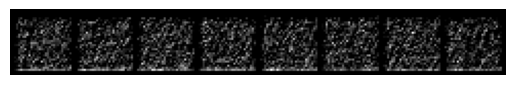

In [131]:
model = BasicUNet()
input_data = torch.rand(8, 1, 28, 28)
pred = model(input_data)

plt.imshow(torchvision.utils.make_grid(pred.detach().cpu())[0], cmap="gray")
plt.axis("off")
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

epoch=000 avg_loss=0.02325
epoch=001 avg_loss=0.01888
epoch=002 avg_loss=0.01795
epoch=003 avg_loss=0.01745
epoch=004 avg_loss=0.01696
epoch=005 avg_loss=0.01695
epoch=006 avg_loss=0.01640
epoch=007 avg_loss=0.01563
epoch=008 avg_loss=0.01490
epoch=009 avg_loss=0.01456
epoch=010 avg_loss=0.01415
epoch=011 avg_loss=0.01405
epoch=012 avg_loss=0.01394
epoch=013 avg_loss=0.01380
epoch=014 avg_loss=0.01336
epoch=015 avg_loss=0.01335
epoch=016 avg_loss=0.01324
epoch=017 avg_loss=0.01303
epoch=018 avg_loss=0.01293
epoch=019 avg_loss=0.01293


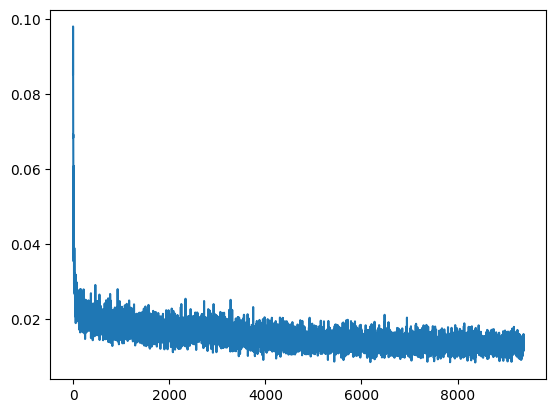

In [132]:
num_epochs = 20

batch_size = 128
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4
)
model = BasicUNet()
model.train()
model.to(__device__)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses = []
preds = []


for epoch in tqdm(range(num_epochs)):
    for x, y in train_dataloader:
        x = x.to(__device__)
        noise_amount = torch.rand(x.shape[0]).to(__device__)
        noisy_x = corrupt(x, noise_amount)
        pred = model(noisy_x)
        loss = loss_fn(pred, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    if epoch == 0:
        preds.append(x.detach().cpu())
    preds.append(pred.detach().cpu())

    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f"{epoch=:03d} {avg_loss=:.05f}")


plt.plot(losses)
plt.show()

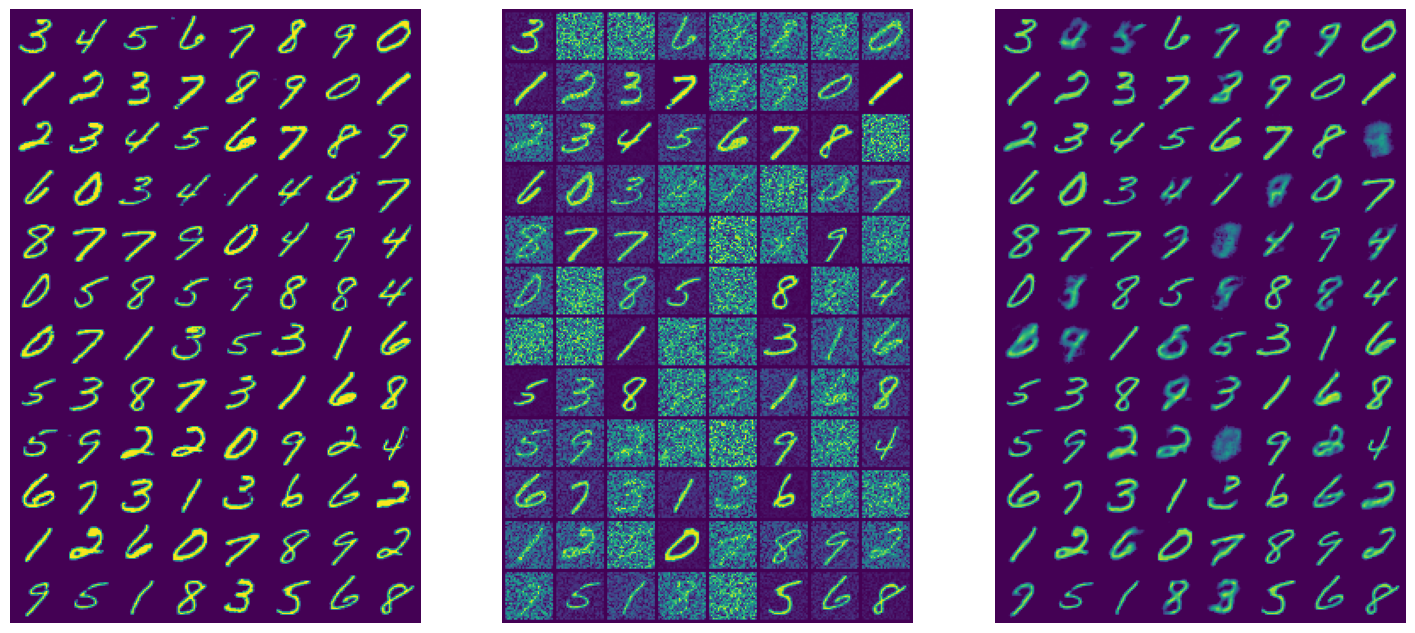

In [133]:
model.eval()
model.cpu()

fig, axes = plt.subplots(1, 3, figsize=(18, 8))
axes[0].imshow(
    torchvision.utils.make_grid(
        x.detach().cpu()
    )[0]
)
axes[0].axis("off")
axes[1].imshow(
    torchvision.utils.make_grid(
        noisy_x.detach().cpu()
    )[0]
)
axes[1].axis("off")
axes[2].imshow(
    torchvision.utils.make_grid(
        pred.detach().cpu()
    )[0]
)
axes[2].axis("off")

plt.show()

noise.shape=torch.Size([64, 3, 3]) | skip_connections[-1].shape=torch.Size([64, 3, 3])


RuntimeError: The size of tensor a (6) must match the size of tensor b (3) at non-singleton dimension 2

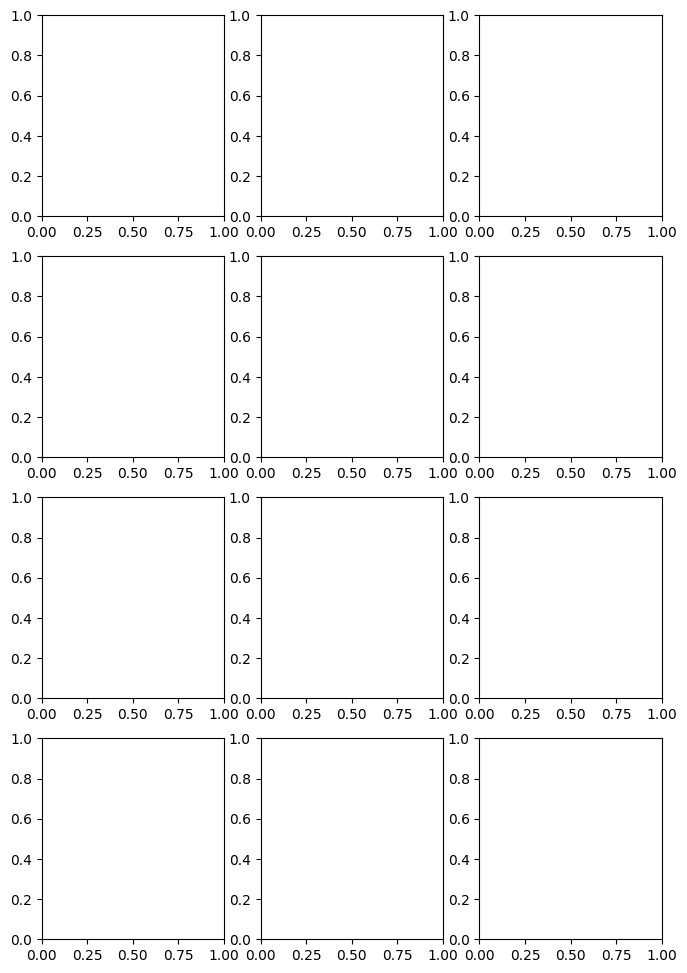

In [147]:
fig, axes = plt.subplots(4, 3, figsize=(8, 12))
model.eval()
model.to(__device__)

for i, row in enumerate(axes):
    x = train_dataset[i][0][0:1].detach().to(__device__)
    noise = x.detach().clone()
    skip_connections = []

    for t, layer in enumerate(model.down_sampling_layers):
        noise = model.activation(layer(noise))
        if t < 2:
            skip_connections.append(noise)
            noise = model.down_scale(noise)

    pred = noise.detach().clone()
    for t, layer in enumerate(model.up_sampling_layers):
        if t > 0:
            print(f"{noise.shape=} | {skip_connections[-1].shape=}")
            pred = model.up_scale(pred)
            pred = pred + skip_connections.pop()
        pred = model.activation(layer(pred))

    print(f"{x.shape=}, {noise.shape=}, {pred.shape=}")
    data = [x, noise[0:1], pred]
    data = [d.detach().cpu() for d in data]
    for j, _ in enumerate(row):
        axes[i, j].imshow(data[j].permute(1, 2, 0), cmap="gray")
        axes[i, j].axis("off")
plt.show()

4


  0%|          | 0/4 [00:00<?, ?it/s]

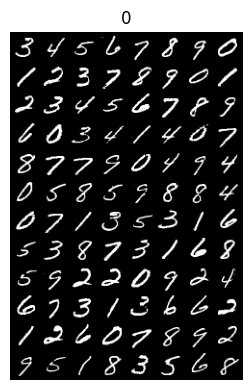

In [68]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = (1024 ** 2) * 1024


fig = plt.figure(figsize=(3, 6))
ax = fig.add_subplot(111)


def anim_plot(index):
    ax.cla()
    ax.imshow(
        torchvision.utils.make_grid(
            preds[index]
        )[0], cmap="gray"
    )
    ax.set_title(index)
    ax.axis("off")

print(len(preds))
animation = ani.FuncAnimation(fig, anim_plot, frames=tqdm(range(len(preds))))
plt.axis("off")
HTML(animation.to_html5_video())